In [1]:
import glob
from path import Path
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import OpenEXR as exr
import Imath

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import pdb
import time

### We will read all the data points in Synscapes depth directory and try to analyze the data
- Synscapes paper says that the depth in .exr files is planar depth in meters which is not the same as distance to the object from camera
- For distance measurement along the Z dimension (Z axis goes out of image plane towards the environment), we need to take into account the focal length
- Minor detail but worth keep note of

In [2]:
def get_depthfromexr(fname):
    exrfile = exr.InputFile(fname)
    header = exrfile.header()
    dw = header['dataWindow']
    isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)
    channelData = dict()
    # convert all channels in the image to numpy arrays
    for c in header['channels']:
        C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
        # C = np.fromstring(C, dtype=np.float32)
        C = np.frombuffer(C, dtype=np.float32)
        C = np.reshape(C, isize)

        channelData[c] = C

    Z = None if 'Z' not in header['channels'] else channelData['Z']
    return Z

In [3]:
# read all thr files in depth directory
root_dir = Path("C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/depth")
depth_fnames = glob.glob(root_dir/"*.exr")
print(len(depth_fnames))

25000


In [4]:
# read one file data and check the data type
depth_data = get_depthfromexr(depth_fnames[0])
depth_data_shape = depth_data.shape
print(depth_data_shape, type(depth_data))

(720, 1440) <class 'numpy.ndarray'>


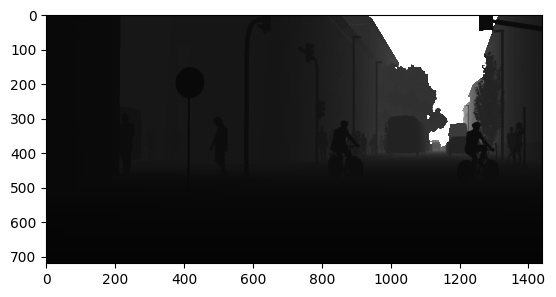

In [5]:
#lets visualize it as an image
plt.figure()
plt.imshow(depth_data, cmap='gray', vmin=0, vmax=300)

- closer the object, darker it appears -> means its closer towards vmin (i.e. 0)
- further the object, whiter is appers -> means towards vmax (i.e. 300)
- if we dont set vmin and vmax, you will see only white portion and everything else close to black due to huge dynamic range

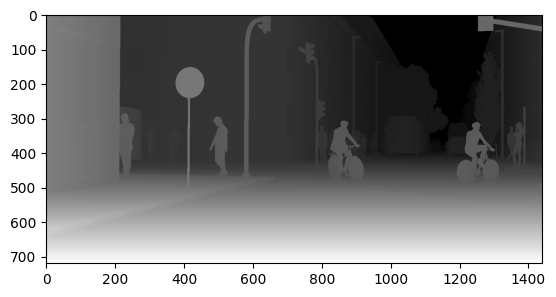

In [6]:
# we can convert the depth data to disparity map just by inverting it
disparity_data = 1/depth_data
plt.figure()
plt.imshow(disparity_data, cmap='gray')

- so in disparity map, farther the object, more black it will be
- nearer the object, more white it will be

- So it 2D np array with H=720, W=1440

In [7]:
# compute the stats for depth data as we load each file
# stats = [(min, max, mean, std)]
stats = []
for file in tqdm(depth_fnames):
    depth_data = get_depthfromexr(file)
    stats.append((depth_data.min(), depth_data.max(), depth_data.mean(), depth_data.std()))

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [07:31<00:00, 55.34it/s]


In [17]:
stats = np.array(stats)
print(f"---- Depth stats across entire data set --------")
print(f"min depth : {stats[:,0].min()}")
print(f"max depth : {stats[:,1].max()}")
print(f"mean depth : {stats[:,2].mean()}")
print(f"std depth : {stats[:,3].std()}")

---- Depth stats across entire data set --------
min depth : 0.0847182646393776
max depth : 9101.5869140625
mean depth : 763.7706909179688
std depth : 690.6525268554688


In [21]:
dep

array([[10.817817 , 10.827071 , 10.836959 , ..., 31.427792 , 31.353333 ,
        31.232756 ],
       [10.818541 , 10.827236 , 10.837154 , ..., 31.42954  , 31.346485 ,
        31.232964 ],
       [10.817946 , 10.828008 , 10.836664 , ..., 31.42917  , 31.352726 ,
        31.239977 ],
       ...,
       [ 5.439752 ,  5.4397526,  5.4393287, ...,  5.438908 ,  5.4385448,
         5.437089 ],
       [ 5.4228964,  5.4228225,  5.424554 , ...,  5.4219503,  5.423471 ,
         5.423293 ],
       [ 5.4091988,  5.40822  ,  5.4098444, ...,  5.408236 ,  5.408308 ,
         5.4074984]], dtype=float32)

In [39]:
# we constrain max depth=300, min_depth=4 and compute mean and std for this constrained depth data
min_depth, max_depth = 4, 300 # metres
stats_filtered = []
sum_cnt, sumsq_cnt = 0, 0
for file in tqdm(depth_fnames):
    depth_data = get_depthfromexr(file)
    flag = np.logical_and(depth_data >= min_depth, depth_data <= max_depth)
    sum_cnt += depth_data[flag].sum()
    sumsq_cnt += (depth_data[flag]**2).sum()
    
meanval = sum_cnt/(len(depth_fnames)*depth_data.shape[0]*depth_data.shape[1])
stdval = sumsq_cnt/(len(depth_fnames)*depth_data.shape[0]*depth_data.shape[1]) - meanval**2
print(f"meanval: {meanval}")
print(f"stdval: {stdval}")

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [08:24<00:00, 49.55it/s]

meanval: 23.900889477336516
stdval: 735.2418005652928


In [40]:
print(f"meanval: {meanval}")
print(f"stdval: {np.sqrt(stdval)}")

meanval: 23.900889477336516
stdval: 27.115342530849446


In [37]:
depth_data[flag].shape, flag.shape, depth_data.shape, 720*1440, flag.sum()

((975632,), (720, 1440), (720, 1440), 1036800, 975632)

- Pheww.... it took so long to run
- lets flex our python muscles and parallelize the multiple file reading

In [15]:
stats_ = []
start_time = time.time()
with ProcessPoolExecutor(max_workers=8) as executor:
    depth_data = executor.map(get_depthfromexr, depth_fnames) # map return an map object iterator, so do next on it to get the data
    #stats_.append(depth_data)
print(f"time taken: {time.time() - start_time}")
# compute the stats
#stats = [ for o in stats_]

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

- Unfortunately, the ProcessPoolExecutor does not run in interactive kernel like jupyter notebook, we need to write the code in .py file and need to define if __name__ == "__main__", then it runs
- I checked it takes about 2.5ms vs 8.5ms w/o parallel processing

In [19]:
depth_data